# Bike Sharing Dataset

For this project, we use the Bike Sharing Dataset available at https://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset . Our goal is to predict for a day the count of hourly bike rentals.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
import seaborn as sns
import statistics as stat
from datetime import datetime,timedelta
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor, ExtraTreesRegressor, GradientBoostingRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn import svm
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_absolute_error

In [2]:
day=pd.read_csv('/Users/emintatar/Job Application/computer_science_jobs/blue_yonder/challenge/Bike-Sharing-Dataset/day.csv')
hour=pd.read_csv('/Users/emintatar/Job Application/computer_science_jobs/blue_yonder/challenge/Bike-Sharing-Dataset/hour.csv')

In [3]:
print(day.info(null_counts=True))
print(hour.info(null_counts=True))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 16 columns):
instant       731 non-null int64
dteday        731 non-null object
season        731 non-null int64
yr            731 non-null int64
mnth          731 non-null int64
holiday       731 non-null int64
weekday       731 non-null int64
workingday    731 non-null int64
weathersit    731 non-null int64
temp          731 non-null float64
atemp         731 non-null float64
hum           731 non-null float64
windspeed     731 non-null float64
casual        731 non-null int64
registered    731 non-null int64
cnt           731 non-null int64
dtypes: float64(4), int64(11), object(1)
memory usage: 91.5+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
instant       17379 non-null int64
dteday        17379 non-null object
season        17379 non-null int64
yr            17379 non-null int64
mnth          17379 non-null int64
hr  

Create a datetime object to conveniently visualize and slice the dataframes:

In [4]:
date_drng = pd.date_range(start=day['dteday'].iloc[0], end=day['dteday'].iloc[-1], freq='D')
day['date']=date_drng
day['date']=pd.to_datetime(day['date'])

In [5]:
date_time=list()
for i in range(len(hour['hr'])):
    date_time.append(datetime.strptime(hour['dteday'].iloc[i]+str(hour['hr'].iloc[i]),"%Y-%m-%d%H"))
hour['datetime']=date_time

## Explanotary Data Analysis (Over All Look)

First we look at the total rentals per season, month, day, and hour:

[Text(0, 0, ''),
 Text(0, 0, '200'),
 Text(0, 0, '400'),
 Text(0, 0, '600'),
 Text(0, 0, '800'),
 Text(0, 0, '1000'),
 Text(0, 0, '')]

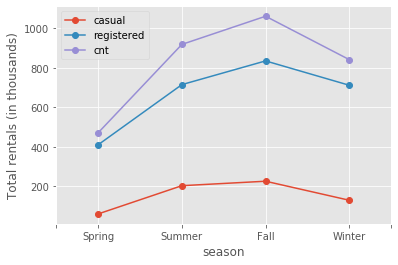

In [6]:
ax_s=hour.groupby('season')[['casual','registered','cnt']].sum().plot(marker='o')
ax_s.set_xticks([0.5,1,2,3,4,4.5])
ax_s.set_xticklabels(['','Spring','Summer','Fall','Winter',''])
ax_s.set_ylabel('Total rentals (in thousands)')
ax_s.set_yticklabels(['','200','400','600','800','1000',''])

[Text(0, 0, ''),
 Text(0, 0, '0'),
 Text(0, 0, '50'),
 Text(0, 0, '100'),
 Text(0, 0, '150'),
 Text(0, 0, '200'),
 Text(0, 0, '250'),
 Text(0, 0, '300'),
 Text(0, 0, '350'),
 Text(0, 0, '400')]

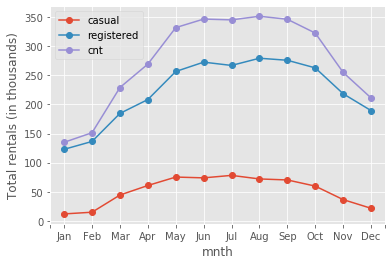

In [7]:
ax_m=hour.groupby('mnth')[['casual','registered','cnt']].sum().plot(marker='o')
ax_m.set_xticks([0.5,1,2,3,4,5,6,7,8,9,10,11,12,12.5])
ax_m.set_xticklabels(['','Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec',''])
ax_m.set_ylabel('Total rentals (in thousands)')
ax_m.set_yticklabels(['','0','50','100','150','200','250','300','350','400'])

[Text(0, 0, ''),
 Text(0, 0, '100'),
 Text(0, 0, '200'),
 Text(0, 0, '300'),
 Text(0, 0, '400'),
 Text(0, 0, '500'),
 Text(0, 0, '')]

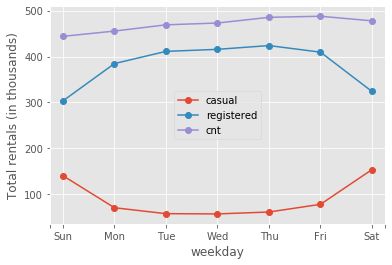

In [8]:
ax_d=hour.groupby('weekday')[['casual','registered','cnt']].sum().plot(marker='o')
ax_d.set_xticks([-0.25,0,1,2,3,4,5,6,6.25])
ax_d.set_xticklabels(['','Sun','Mon','Tue','Wed','Thu','Fri','Sat',''])
ax_d.set_ylabel('Total rentals (in thousands)')
ax_d.set_yticklabels(['','100','200','300','400','500',''])

[Text(0, 0, ''),
 Text(0, 0, '50'),
 Text(0, 0, '100'),
 Text(0, 0, '150'),
 Text(0, 0, '200'),
 Text(0, 0, '250'),
 Text(0, 0, '300'),
 Text(0, 0, '350'),
 Text(0, 0, '400')]

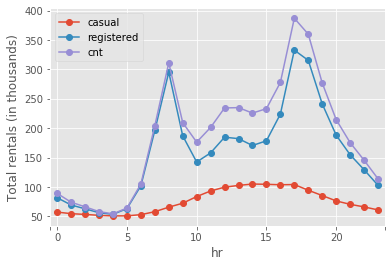

In [9]:
ax_h=hour.groupby('hr')[['casual','registered','cnt']].sum().plot(marker='o')
ax_h.set_xticks([-0.5,0,5,10,15,20,23.5])
ax_h.set_xticklabels(['',0,5,10,15,20,''])
ax_h.set_ylabel('Total rentals (in thousands)')
ax_h.set_yticklabels(['','50','100','150','200','250','300','350','400'])

From these plots, we observe that the pattern of bike rental by registered users is very similar to the pattern of the bike rentals by all users and the pattern of the bike rentals by registered users is completly different than the pattern of the casual users.

## First Model

In our first model, we test many regressors on hourly datset which is split randomly into two as training and testing datasets in the ratio of 7:3. We start with changing the categorical features into dummy features:

In [10]:
hour['season_cat']=hour['season'].astype('category')
hour['yr_cat']=hour['yr'].astype('category')
hour['mnth_cat']=hour['mnth'].astype('category')
hour['hr_cat']=hour['hr'].astype('category')
hour=pd.get_dummies(hour,columns=['season_cat','yr_cat','mnth_cat','hr_cat'],prefix_sep='_')

We verify the correlation between the continuous features:

[Text(0.5, 0, 'temp'),
 Text(1.5, 0, 'atemp'),
 Text(2.5, 0, 'hum'),
 Text(3.5, 0, 'windspeed'),
 Text(4.5, 0, 'cnt')]

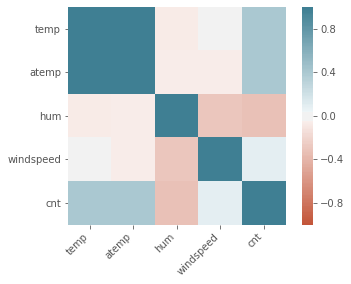

In [11]:
#correlation heat map
hour_continuous=hour[['temp','atemp','hum','windspeed','cnt']]
corr = hour_continuous.corr()
ax = sns.heatmap(corr, vmin=-1, vmax=1, center=0,cmap=sns.diverging_palette(20, 220, n=200),square=True,)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45,horizontalalignment='right')

According to the heatmap, the features temp and atemp are higly correlated. Therefore, we only include one of them and we choose atemp. The data we use for training and testing is obtained as follows:

In [12]:
keep=['season_cat_2','season_cat_3','season_cat_4','yr_cat_1','mnth_cat_2','mnth_cat_3','mnth_cat_4','mnth_cat_5',
      'mnth_cat_6','mnth_cat_7','mnth_cat_8','mnth_cat_9','mnth_cat_10','mnth_cat_11','mnth_cat_12','hr_cat_1',
      'hr_cat_2','hr_cat_3','hr_cat_4','hr_cat_5','hr_cat_6','hr_cat_7','hr_cat_8','hr_cat_9','hr_cat_10','hr_cat_11',
      'hr_cat_12','hr_cat_13','hr_cat_14','hr_cat_15','hr_cat_16','hr_cat_17','hr_cat_18','hr_cat_19','hr_cat_20',
      'hr_cat_21','hr_cat_22','hr_cat_23','weathersit','atemp','hum','windspeed']
X=hour[keep]
y=hour['cnt']
X_train,X_test,y_train,y_test=train_test_split(X,y,train_size=0.7,test_size=0.3,random_state=1654)

We use the following regressors:

In [13]:
linr=LinearRegression()
dtr=DecisionTreeRegressor()
br=BaggingRegressor()
etr=ExtraTreesRegressor(n_estimators=10)
gbr=GradientBoostingRegressor()
rfr=RandomForestRegressor(n_estimators=10)
knnr=KNeighborsRegressor()
svmr=svm.SVR(gamma='auto')
models={'linr':linr,'dtr':dtr,'br':br,'etr':etr,'gbr':gbr,'rfr':rfr,'knnr':knnr,'svmr':svmr}

In [14]:
pred=pd.DataFrame(columns=['linr','dtr','br','etr','gbr','rfr','knnr','svmr'])
mad={'linr':0,'dtr':0,'br':0,'etr':0,'gbr':0,'rfr':0,'knnr':0,'svmr':0}
for clt in models.keys():
    model=models[clt]
    model.fit(X_train,y_train)
    prediction=model.predict(X_test)
    pred[clt]=prediction
    mad[clt]=np.abs(y_test-prediction).mean()

In [15]:
print(mad)

{'linr': 75.42438964527742, 'dtr': 78.25172612197929, 'br': 63.07184261238061, 'etr': 63.23667050249332, 'gbr': 69.54058991791268, 'rfr': 63.9828824867116, 'knnr': 62.736325278097524, 'svmr': 118.5270802998168}


The above numbers mean that in average our hourly estimations are wrong by that many bicycles. According to these numbers, the best regressor is ExtraTrees (ETR).  The default number of trees is 10 for the ETR. We can look for the number of trees using cross validation that will improve its performance. However doing such a gridsearch is not time efficient. Therefore we try KNeighborhood regressor (KNNR) which is not an ensemble method like ETR but performs almost as good as ETR. To improve its performance, we do gridsearch over the number of neighboorhoods with 5-fold cross validation.

In [16]:
pipeline=Pipeline([('knnr',KNeighborsRegressor())])
parameters=[{'knnr__n_neighbors':[3,4,5,6,7,8,9,10,11,12,13,14,15]}]
fold=KFold(5,shuffle=True,random_state=0)
mae=make_scorer(mean_absolute_error,greater_is_better=False)
grid=GridSearchCV(pipeline,parameters,cv=fold,return_train_score=True,scoring=mae)
grid.fit(X_train,y_train)
predict_knnr=grid.predict(X_test)
mad_knnr=np.abs(y_test-predict_knnr).mean()
CVR_knnr=grid.cv_results_

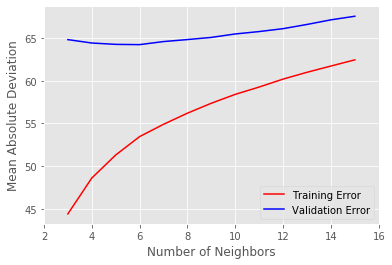

In [17]:
test_scores=-CVR_knnr['mean_test_score']
train_scores=-CVR_knnr['mean_train_score']
plt.plot([3,4,5,6,7,8,9,10,11,12,13,14,15],train_scores,c='r',label='Training Error')
plt.plot([3,4,5,6,7,8,9,10,11,12,13,14,15],test_scores,c='b',label='Validation Error')
plt.xticks([2,4,6,8,10,12,14,16])
plt.xlabel('Number of Neighbors')
plt.ylabel('Mean Absolute Deviation')
plt.legend()

The above plot shows, as expected, that the smaller the number of neighbors the less stable the regression is.

In [18]:
print('best number of neighbors:',grid.best_params_['knnr__n_neighbors'])
print('best validation score:',-grid.best_score_)
print('test score:',mad_knnr)

best number of neighbors: 6
best validation score: 64.21912590765858
test score: 63.13166474875336


The sketch of Mean Absolute Deviation of training and validation per number of neighbors show that 6 is the best number of neigbors.

## Explanotary Data Analysis (Daily Look)

Acording to the above model, we can predict the hourly bike rentals by an error of approximately 18 bicycles in average. Even if the performance of this model might be good, it is not a very realistic model. As we split the data randomly, we might and most probably are using the information from the future to predict the past. Therefore we want to develop a model where we will predict the hourly bike rentals only by using the information prior to that moment. To be more precise, our next model will predict hourly rentals of one day by using the hourly rental information of the previous days. 

Let us have allok at the hourly total rental by days of the week.

Text(0.5, 0, 'Hours')

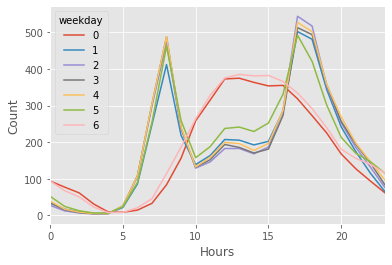

In [19]:
days=hour.groupby(['weekday','hr'])['cnt'].mean()
days.unstack(level=0).plot()
plt.ylabel('Count')
plt.xlabel('Hours')

We observe that the rental pattern of weekdays (two peaks) is different than the rental patterns of the weekend(one peak). So we seperate our days as working and not working days.

In [20]:
workingdays=hour.loc[(hour['workingday']==1) &(hour['weekday']%6!=0)]
notworkingdays=hour.loc[(hour['workingday']==0) | (hour['weekday']%6==0)]

## Second Model
We develop a prediction function with single varibale being the date on which we want to predict the hourly rentals.  Based on our findings in the first model, this predcition function will train a KNNR model using the data before the input date and will output the predictions for the input date.  

In [21]:
def knnr_predict_oneday(date):
    day_begin=datetime.strptime(date,"%Y-%m-%d")
    day_end=datetime.strptime(date,"%Y-%m-%d")+timedelta(hours=23)
    if (hour.loc[hour['datetime']==date]['workingday']==1).bool():
        day_type=1
        trainingdays=workingdays.loc[day_begin>hour['datetime']]
        testday=workingdays.loc[(day_begin<=hour['datetime'])&(day_end>=hour['datetime'])]
    else:
        day_type=0
        trainingdays=notworkingdays.loc[day_begin>hour['datetime']]
        testday=notworkingdays.loc[(day_begin<=hour['datetime'])&(day_end>=hour['datetime'])]
    X_train=np.array(trainingdays[keep])
    y_train=np.array(trainingdays['cnt'])
    X_test=np.array(testday[keep])
    y_test=np.array(testday['cnt'])
    pipeline=Pipeline([('knnr',KNeighborsRegressor())])
    parameters=[{'knnr__n_neighbors':[3+i for i in range(13) if 3+i<4/5*X_train.shape[0]]}]
    grid=GridSearchCV(pipeline,parameters,cv=fold,iid=True)
    grid.fit(X_train,y_train)
    y_pred=grid.predict(X_test)
    mad=np.abs((y_test-y_pred)).mean()
    return {'Date':date,'Day':day_type,'MAD':mad,'Observed':y_test,'Predicted':y_pred}   

Our model first checks whether the input day is a working day or not. Then based on the type of the day, it only uses the same type of previous days for training. Below we try our function on couple of days and we plot our predcited hourly bike rentals against the observed ones for that day:

MAD: 12.069444444444443


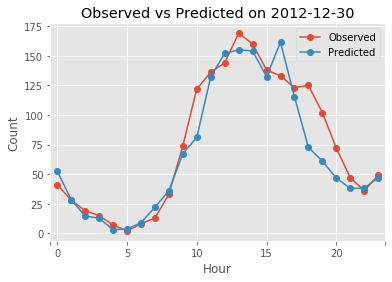

In [22]:
#A non working day
result=knnr_predict_oneday('2012-12-30')
counts=pd.DataFrame({'Observed':result['Observed'],'Predicted':result['Predicted']})
date=result['Date']
counts_plot=counts.plot(title='Observed vs Predicted on '+date,label='actual',fontsize=10,marker='o')
counts_plot.set_xlabel('Hour')
counts_plot.set_ylabel('Count')
counts_plot.set_xticks([-0.5,0,5,10,15,20,23.5])
counts_plot.set_xticklabels(['',0,5,10,15,20,''])
print('MAD:',result['MAD'])

MAD: 57.447916666666664


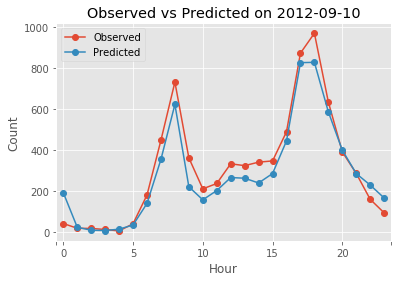

In [23]:
#A working day
result=knnr_predict_oneday('2012-09-10')
counts=pd.DataFrame({'Observed':result['Observed'],'Predicted':result['Predicted']})
date=result['Date']
counts_plot=counts.plot(title='Observed vs Predicted on '+date,label='actual',fontsize=10,marker='o')
counts_plot.set_xlabel('Hour')
counts_plot.set_ylabel('Count')
counts_plot.set_xticks([-0.5,0,5,10,15,20,23.5])
counts_plot.set_xticklabels(['',0,5,10,15,20,''])
print('MAD:',result['MAD'])

From the above plots, we see that we are most of the time underestimating. This is, especially during the pick hours, is not good for bussiness as it means returning customers. So we look for another model. The next model we propose is based on the classical linear regression. We fit piece-wise degree d multivariate polynomials. From the daily sketchs, we decide to divide a working day in to 7 time zones namely $[0, 4), [4, 8), [8, 10), [10, 12), [12, 14), [14, 18)$, and $[18, 23]$ and a non working day in to 3 time zones $[0, 4), [4, 16)$,and $[16, 23]$.

In [24]:
def linear_predict_oneday(date):
    day_begin=datetime.strptime(date,"%Y-%m-%d")
    day_end=datetime.strptime(date,"%Y-%m-%d")+timedelta(hours=23)
    if (hour.loc[hour['datetime']==date]['workingday']==1).bool():
        daytype=1
        testday=workingdays.loc[(day_begin<=hour['datetime'])&(day_end>=hour['datetime'])]
        trainingdays=workingdays.loc[day_begin>hour['datetime']]
        train_zone1=trainingdays.loc[(trainingdays['hr']<4)&(trainingdays['hr']>=0)]
        train_zone2=trainingdays.loc[(trainingdays['hr']<8)&(trainingdays['hr']>=4)]
        train_zone3=trainingdays.loc[(trainingdays['hr']<10)&(trainingdays['hr']>=8)]
        train_zone4=trainingdays.loc[(trainingdays['hr']<12)&(trainingdays['hr']>=10)]
        train_zone5=trainingdays.loc[(trainingdays['hr']<14)&(trainingdays['hr']>=12)]
        train_zone6=trainingdays.loc[(trainingdays['hr']<18)&(trainingdays['hr']>=14)]
        train_zone7=trainingdays.loc[(trainingdays['hr']<=23)&(trainingdays['hr']>=18)]
        test_zone1=testday.loc[(testday['hr']<4)&(testday['hr']>=0)]
        test_zone2=testday.loc[(testday['hr']<8)&(testday['hr']>=4)]
        test_zone3=testday.loc[(testday['hr']<10)&(testday['hr']>=8)]
        test_zone4=testday.loc[(testday['hr']<12)&(testday['hr']>=10)]
        test_zone5=testday.loc[(testday['hr']<14)&(testday['hr']>=12)]
        test_zone6=testday.loc[(testday['hr']<18)&(testday['hr']>=14)]
        test_zone7=testday.loc[(testday['hr']<=23)&(testday['hr']>=18)]
        X1_train=np.array(train_zone1[keep])
        X2_train=np.array(train_zone2[keep])
        X3_train=np.array(train_zone3[keep])
        X4_train=np.array(train_zone4[keep])
        X5_train=np.array(train_zone5[keep])
        X6_train=np.array(train_zone6[keep])
        X7_train=np.array(train_zone7[keep])
        y1_train=np.array(train_zone1['cnt'])
        y2_train=np.array(train_zone2['cnt'])
        y3_train=np.array(train_zone3['cnt'])
        y4_train=np.array(train_zone4['cnt'])
        y5_train=np.array(train_zone5['cnt'])
        y6_train=np.array(train_zone6['cnt'])
        y7_train=np.array(train_zone7['cnt'])
        X1_test=np.array(test_zone1[keep])
        X2_test=np.array(test_zone2[keep])
        X3_test=np.array(test_zone3[keep])
        X4_test=np.array(test_zone4[keep])
        X5_test=np.array(test_zone5[keep])
        X6_test=np.array(test_zone6[keep])
        X7_test=np.array(test_zone7[keep])
        y1_test=np.array(test_zone1['cnt'])
        y2_test=np.array(test_zone2['cnt'])
        y3_test=np.array(test_zone3['cnt'])
        y4_test=np.array(test_zone4['cnt'])
        y5_test=np.array(test_zone5['cnt'])
        y6_test=np.array(test_zone6['cnt'])
        y7_test=np.array(test_zone7['cnt'])
        X_train=[X1_train,X2_train,X3_train,X4_train,X5_train,X6_train,X7_train]
        X_test=[X1_test,X2_test,X3_test,X4_test,X5_test,X6_test,X7_test]
        y_train=[y1_train,y2_train,y3_train,y4_train,y5_train,y6_train,y7_train]
        y_test=[y1_test,y2_test,y3_test,y4_test,y5_test,y6_test,y7_test]
        obs=np.concatenate([y1_test,y2_test,y3_test,y4_test,y5_test,y6_test,y7_test])
    else:
        daytype=0
        testday=notworkingdays.loc[(day_begin<=hour['datetime'])&(day_end>=hour['datetime'])]
        trainingdays=notworkingdays.loc[day_begin>hour['datetime']]
        train_zone1=trainingdays.loc[(trainingdays['hr']<4)&(trainingdays['hr']>=0)]
        train_zone2=trainingdays.loc[(trainingdays['hr']<16)&(trainingdays['hr']>=4)]
        train_zone3=trainingdays.loc[(trainingdays['hr']<=23)&(trainingdays['hr']>=16)]
        test_zone1=testday.loc[(testday['hr']<4)&(testday['hr']>=0)]
        test_zone2=testday.loc[(testday['hr']<16)&(testday['hr']>=4)]
        test_zone3=testday.loc[(testday['hr']<=23)&(testday['hr']>=16)]
        X1_train=np.array(train_zone1[keep])
        X2_train=np.array(train_zone2[keep])
        X3_train=np.array(train_zone3[keep])
        y1_train=np.array(train_zone1['cnt'])
        y2_train=np.array(train_zone2['cnt'])
        y3_train=np.array(train_zone3['cnt'])
        X1_test=np.array(test_zone1[keep])
        X2_test=np.array(test_zone2[keep])
        X3_test=np.array(test_zone3[keep])
        y1_test=np.array(test_zone1['cnt'])
        y2_test=np.array(test_zone2['cnt'])
        y3_test=np.array(test_zone3['cnt'])
        X_train=[X1_train,X2_train,X3_train]
        X_test=[X1_test,X2_test,X3_test]
        y_train=[y1_train,y2_train,y3_train]
        y_test=[y1_test,y2_test,y3_test]
        obs=np.concatenate([y1_test,y2_test,y3_test])
    method = Pipeline([('poly', PolynomialFeatures(degree=2)),('linear', LinearRegression(fit_intercept=False))])
    pred=list()
    for i,(X_t,y_t,X_v,y_v) in enumerate(zip(X_train,y_train,X_test,y_test)):
        method.fit(X_t,y_t)
        pred.extend(method.predict(X_v))
        for i in range(len(pred)):
            if pred[i]<0 or pred[i]>1e4:
                pred[i]=0  
    mad=np.abs(obs-pred).mean()
    results={'Day':daytype,'Date':date,'MAD':mad,'Observed':obs,'Predicted':pred}
    return results

Let us test this prediction fucntion on the same dates.

MAD: 18.905379917418696


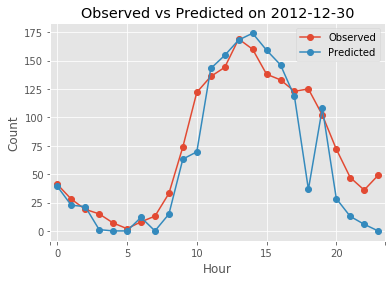

In [25]:
#A non working day
result=linear_predict_oneday('2012-12-30')
counts=pd.DataFrame({'Observed':result['Observed'],'Predicted':result['Predicted']})
date=result['Date']
counts_plot=counts.plot(title='Observed vs Predicted on '+date,label='actual',fontsize=10,marker='o')
counts_plot.set_xlabel('Hour')
counts_plot.set_ylabel('Count')
counts_plot.set_xticks([-0.5,0,5,10,15,20,23.5])
counts_plot.set_xticklabels(['',0,5,10,15,20,''])
print('MAD:',result['MAD'])

MAD: 35.26324462890625


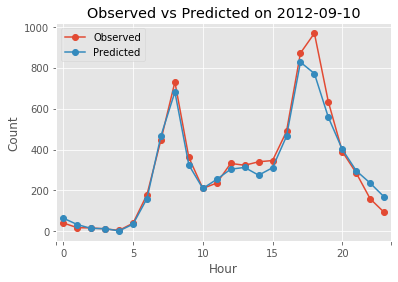

In [26]:
#A working day
result=linear_predict_oneday('2012-09-10')
counts=pd.DataFrame({'Observed':result['Observed'],'Predicted':result['Predicted']})
date=result['Date']
counts_plot=counts.plot(title='Observed vs Predicted on '+date,label='actual',fontsize=10,marker='o')
counts_plot.set_xlabel('Hour')
counts_plot.set_ylabel('Count')
counts_plot.set_xticks([-0.5,0,5,10,15,20,23.5])
counts_plot.set_xticklabels(['',0,5,10,15,20,''])
print('MAD:',result['MAD'])

From these two test dates, we think that the linear prediction will work better on the working days and the KNNR will work better on the non workingdays. So we propose a hybrid model which uses linear prediction on working days and KNNR on the non working days.

In [27]:
def predict_oneday(date):
    if (hour.loc[hour['datetime']==date]['workingday']==1).bool():
        return linear_predict_oneday(date)
    else:
        return knnr_predict_oneday(date)

MAD: 59.40625


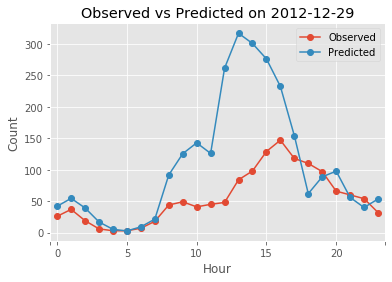

In [29]:
result=predict_oneday('2012-12-29')
counts=pd.DataFrame({'Observed':result['Observed'],'Predicted':result['Predicted']})
date=result['Date']
counts_plot=counts.plot(title='Observed vs Predicted on '+date,label='actual',fontsize=10,marker='o')
counts_plot.set_xlabel('Hour')
counts_plot.set_ylabel('Count')
counts_plot.set_xticks([-0.5,0,5,10,15,20,23.5])
counts_plot.set_xticklabels(['',0,5,10,15,20,''])
print('MAD:',result['MAD'])

In [34]:
exclude_dates=['2011-01-01','2011-08-28','2011-01-03','2011-01-18','2011-01-26','2011-01-27','2011-02-22','2012-10-29','2012-10-30']
result_table=pd.DataFrame(columns=['MAD'],index=range(len(hour['dteday'].unique())))
result_table['season']=hour.drop_duplicates(subset='dteday',keep='first')['season'].reset_index(drop=True)
result_table['weekday']=hour.drop_duplicates(subset='dteday',keep='first')['weekday'].reset_index(drop=True)
result_table['year']=hour.drop_duplicates(subset='dteday',keep='first')['yr'].reset_index(drop=True)

In [47]:
mad=list(result_table['MAD'])
for i,date in enumerate(hour['dteday'].unique()):
    if (date not in exclude_dates):
        mad[i]=predict_oneday(date)['MAD']

In [49]:
result_table['MAD']=mad

Text(0.5, 1.0, '')

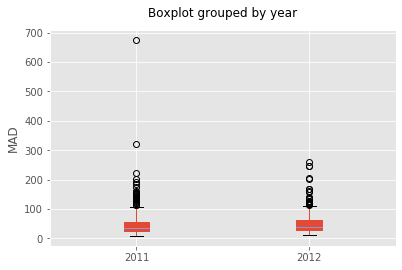

In [50]:
ax_y=result_table.boxplot(column='MAD',by='year',patch_artist=True)
ax_y.set_xticklabels(['2011','2012'])
ax_y.set_xlabel('')
ax_y.set_ylabel('MAD')
ax_y.set_title('')

Text(0.5, 1.0, '')

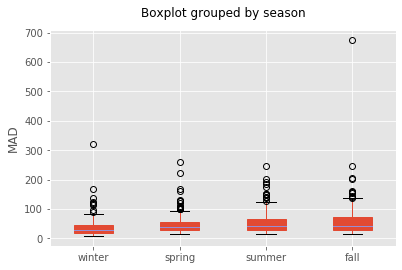

In [51]:
ax_s=result_table.boxplot(column='MAD',by='season',patch_artist=True)
ax_s.set_xticklabels(['winter','spring','summer','fall'])
ax_s.set_xlabel('')
ax_s.set_ylabel('MAD')
ax_s.set_title('')

Text(0.5, 1.0, '')

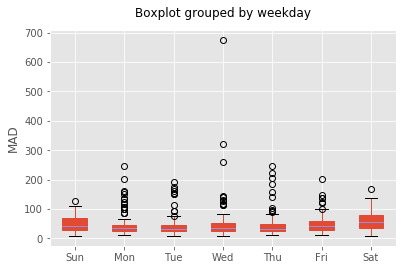

In [53]:
ax_s=result_table.boxplot(column='MAD',by='weekday',patch_artist=True)
ax_s.set_xticklabels(['Sun','Mon','Tue','Wed','Thu','Fri','Sat'])
ax_s.set_xlabel('')
ax_s.set_ylabel('MAD')
ax_s.set_title('')

In [56]:
print(result_table['MAD'].mean())

50.250704318611945


## Conclusion
According to the above boxplots, we predict best the year 2011, the season winter, and the workingdays. Our predictions per day are off by 50 bicycles in average.